# Code- Shubham Jain

In [1]:
import csv
import sqlite3

# File path
file_path = r"C:\Users\proig\Downloads\winequalityN.csv"

# Step 1: Analyze missing values
missing_counts = {}
total_rows = 0
header = []

# Read the file and count missing values
with open(file_path, 'r') as file:
    reader = csv.DictReader(file)
    header = reader.fieldnames
    missing_counts = {col: 0 for col in header}

    for row in reader:
        total_rows += 1
        for col in header:
            if not row[col]:  # Empty or missing value
                missing_counts[col] += 1

# Display missing value counts
print("Missing Values in Each Column:")
for col, count in missing_counts.items():
    print(f"{col}: {count} missing ({(count / total_rows) * 100:.2f}%)")

# Step 2: Calculate column means for handling missing values
column_sums = {col: 0.0 for col in header if col != 'type'}
row_counts = {col: 0 for col in header if col != 'type'}

with open(file_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        for col in column_sums:
            try:
                if row[col]:
                    column_sums[col] += float(row[col])
                    row_counts[col] += 1
            except ValueError:
                continue

column_means = {col: column_sums[col] / row_counts[col] for col in column_sums}

# Step 3: Normalize data into a SQLite database
conn = sqlite3.connect('wine_quality_normalized.db')
cursor = conn.cursor()

# Create tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS Wine (
    wine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    type TEXT NOT NULL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS QualityMetrics (
    metric_id INTEGER PRIMARY KEY AUTOINCREMENT,
    wine_id INTEGER,
    fixed_acidity REAL,
    volatile_acidity REAL,
    citric_acid REAL,
    residual_sugar REAL,
    chlorides REAL,
    free_sulfur_dioxide REAL,
    total_sulfur_dioxide REAL,
    density REAL,
    pH REAL,
    sulphates REAL,
    alcohol REAL,
    quality INTEGER,
    FOREIGN KEY (wine_id) REFERENCES Wine(wine_id)
);
''')

# Insert data into tables
wine_cache = {}

def safe_float(value, column_sum, row_count):
    try:
        return float(value) if value else column_sum / row_count
    except ValueError:
        return column_sum / row_count

with open(file_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Insert into Wine table
        wine_type = row['type']
        if wine_type not in wine_cache:
            cursor.execute("INSERT INTO Wine (type) VALUES (?)", (wine_type,))
            conn.commit()
            wine_cache[wine_type] = cursor.lastrowid
        wine_id = wine_cache[wine_type]

        # Insert into QualityMetrics table
        cursor.execute('''
            INSERT INTO QualityMetrics (
                wine_id, fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides,
                free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            wine_id,
            safe_float(row['fixed acidity'], column_sums['fixed acidity'], row_counts['fixed acidity']),
            safe_float(row['volatile acidity'], column_sums['volatile acidity'], row_counts['volatile acidity']),
            safe_float(row['citric acid'], column_sums['citric acid'], row_counts['citric acid']),
            safe_float(row['residual sugar'], column_sums['residual sugar'], row_counts['residual sugar']),
            safe_float(row['chlorides'], column_sums['chlorides'], row_counts['chlorides']),
            safe_float(row['free sulfur dioxide'], column_sums['free sulfur dioxide'], row_counts['free sulfur dioxide']),
            safe_float(row['total sulfur dioxide'], column_sums['total sulfur dioxide'], row_counts['total sulfur dioxide']),
            safe_float(row['density'], column_sums['density'], row_counts['density']),
            safe_float(row['pH'], column_sums['pH'], row_counts['pH']),
            safe_float(row['sulphates'], column_sums['sulphates'], row_counts['sulphates']),
            safe_float(row['alcohol'], column_sums['alcohol'], row_counts['alcohol']),
            int(row['quality']) if row['quality'] else None
        ))
        conn.commit()

# Close the database connection
conn.close()

print("Database created and populated in 3NF.")


Missing Values in Each Column:
type: 0 missing (0.00%)
fixed acidity: 10 missing (0.15%)
volatile acidity: 8 missing (0.12%)
citric acid: 3 missing (0.05%)
residual sugar: 2 missing (0.03%)
chlorides: 2 missing (0.03%)
free sulfur dioxide: 0 missing (0.00%)
total sulfur dioxide: 0 missing (0.00%)
density: 0 missing (0.00%)
pH: 9 missing (0.14%)
sulphates: 4 missing (0.06%)
alcohol: 0 missing (0.00%)
quality: 0 missing (0.00%)


KeyboardInterrupt: 

In [4]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('wine_quality_normalized.db')

# SQL join query to combine `Wine` and `QualityMetrics` tables
query = '''
SELECT
    wm.metric_id,
    w.type AS wine_type,
    wm.fixed_acidity,
    wm.volatile_acidity,
    wm.citric_acid,
    wm.residual_sugar,
    wm.chlorides,
    wm.free_sulfur_dioxide,
    wm.total_sulfur_dioxide,
    wm.density,
    wm.pH,
    wm.sulphates,
    wm.alcohol,
    wm.quality
FROM
    QualityMetrics wm
JOIN
    Wine w ON wm.wine_id = w.wine_id;
'''

# Execute the query and load data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the DataFrame
print(df)


      metric_id wine_type  fixed_acidity  volatile_acidity  citric_acid  \
0             1     white            7.0             0.270         0.36   
1             2     white            6.3             0.300         0.34   
2             3     white            8.1             0.280         0.40   
3             4     white            7.2             0.230         0.32   
4             5     white            7.2             0.230         0.32   
...         ...       ...            ...               ...          ...   
6492       6493       red            6.2             0.600         0.08   
6493       6494       red            5.9             0.550         0.10   
6494       6495       red            6.3             0.510         0.13   
6495       6496       red            5.9             0.645         0.12   
6496       6497       red            6.0             0.310         0.47   

      residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide  \
0               20.7 

Distribution of 'quality':
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


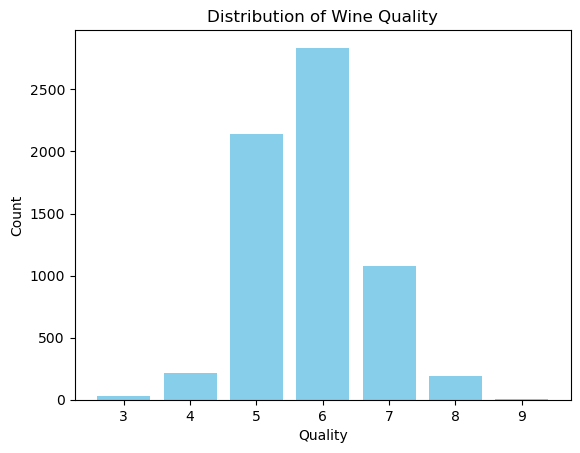

The dataset is imbalanced; stratification will be performed.

Train set quality distribution:
quality
3    0.004618
4    0.033288
5    0.329036
6    0.436598
7    0.166057
8    0.029632
9    0.000770
Name: proportion, dtype: float64

Test set quality distribution:
quality
3    0.004615
4    0.033077
5    0.329231
6    0.436154
7    0.166154
8    0.030000
9    0.000769
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Load data from the database
conn = sqlite3.connect('wine_quality_normalized.db')
query = '''
SELECT
    w.type AS wine_type,
    wm.fixed_acidity,
    wm.volatile_acidity,
    wm.citric_acid,
    wm.residual_sugar,
    wm.chlorides,
    wm.free_sulfur_dioxide,
    wm.total_sulfur_dioxide,
    wm.density,
    wm.pH,
    wm.sulphates,
    wm.alcohol,
    wm.quality
FROM
    QualityMetrics wm
JOIN
    Wine w ON wm.wine_id = w.wine_id;
'''
df = pd.read_sql_query(query, conn)
conn.close()

# Analyze the distribution of 'quality'
quality_counts = df['quality'].value_counts().sort_index()
print("Distribution of 'quality':")
print(quality_counts)

# Visualize the distribution
plt.bar(quality_counts.index, quality_counts.values, color='skyblue')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality')
plt.show()

# Decide if stratification is needed (e.g., for imbalanced distributions)
if (quality_counts.max() / quality_counts.min()) > 2:  # Arbitrary threshold for imbalance
    print("The dataset is imbalanced; stratification will be performed.")

# Train/test split
X = df.drop(columns=['quality'])
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verify the stratification
print("\nTrain set quality distribution:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nTest set quality distribution:")
print(y_test.value_counts(normalize=True).sort_index())


In [7]:
from ydata_profiling import ProfileReport

# Generate a profile report for the dataset
profile = ProfileReport(df, title="Wine Quality Data Profiling", explorative=True)

# Save the report to an HTML file to view it in the browser
profile.to_file("wine_quality_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

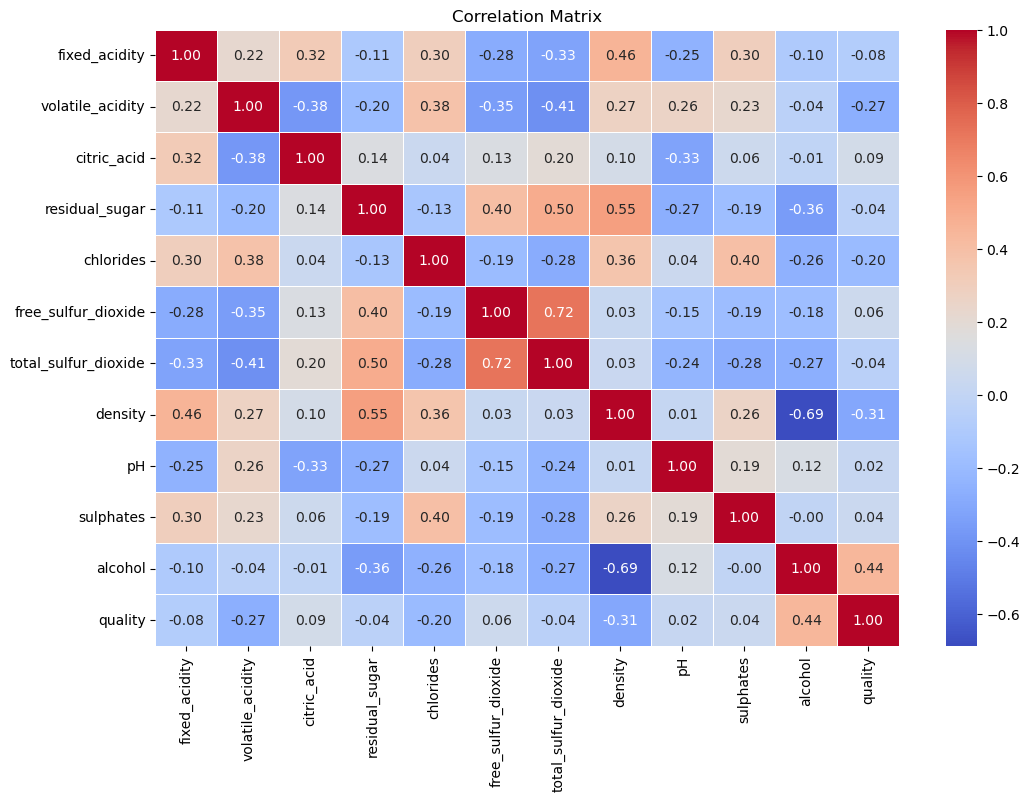

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# If you're in a Jupyter notebook, use this line to render plots inline
%matplotlib inline  

# If you're using a script or terminal environment and need GUI support, switch the backend
#plt.switch_backend('TkAgg')  # Uncomment if using script or terminal with GUI

# Drop categorical columns, assuming 'wine_type' is a categorical column
df_clean = df.select_dtypes(exclude=['object'])  # This will drop non-numeric columns

# Calculate the correlation matrix
correlation_matrix = df_clean.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")

# Save the plot to a file
plt.savefig('correlation_matrix.png')

# Show the plot (if working in an environment that supports it)
plt.show()


In [9]:
missing_values = df.isnull().sum()

# Display missing values per column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
wine_type               0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [10]:
thresholds = {
    'fixed_acidity': (4.0, 16.0),  # (min, max)
    'volatile_acidity': (0.1, 1.5),
    'citric_acid': (0.0, 1.0),
    'residual_sugar': (0.0, 15.0),
    'chlorides': (0.0, 0.1),
    'free_sulfur_dioxide': (0, 60),
    'total_sulfur_dioxide': (0, 200),
    'density': (0.99, 1.05),
    'pH': (2.9, 4.0),
    'sulphates': (0.33, 2.0),
    'alcohol': (8, 15),
}

# Function to check for capped values
def check_capped_values(df, thresholds):
    capped_values = {}
    
    for column, (min_val, max_val) in thresholds.items():
        # Check for values below the min or above the max
        lower_capped = df[column] < min_val
        upper_capped = df[column] > max_val
        
        # Store results
        capped_values[column] = {
            'below_min': lower_capped.sum(),
            'above_max': upper_capped.sum()
        }
    
    return capped_values

# Check capped values
capped_values = check_capped_values(df, thresholds)

# Display results
print("Capped Values (below min or above max):")
for column, counts in capped_values.items():
    print(f"{column}: Below min: {counts['below_min']}, Above max: {counts['above_max']}")

Capped Values (below min or above max):
fixed_acidity: Below min: 2, Above max: 0
volatile_acidity: Below min: 6, Above max: 1
citric_acid: Below min: 0, Above max: 2
residual_sugar: Below min: 0, Above max: 324
chlorides: Below min: 0, Above max: 333
free_sulfur_dioxide: Below min: 0, Above max: 350
total_sulfur_dioxide: Below min: 0, Above max: 393
density: Below min: 345, Above max: 0
pH: Below min: 79, Above max: 2
sulphates: Below min: 172, Above max: 0
alcohol: Below min: 0, Above max: 0


<Figure size 1500x1200 with 0 Axes>

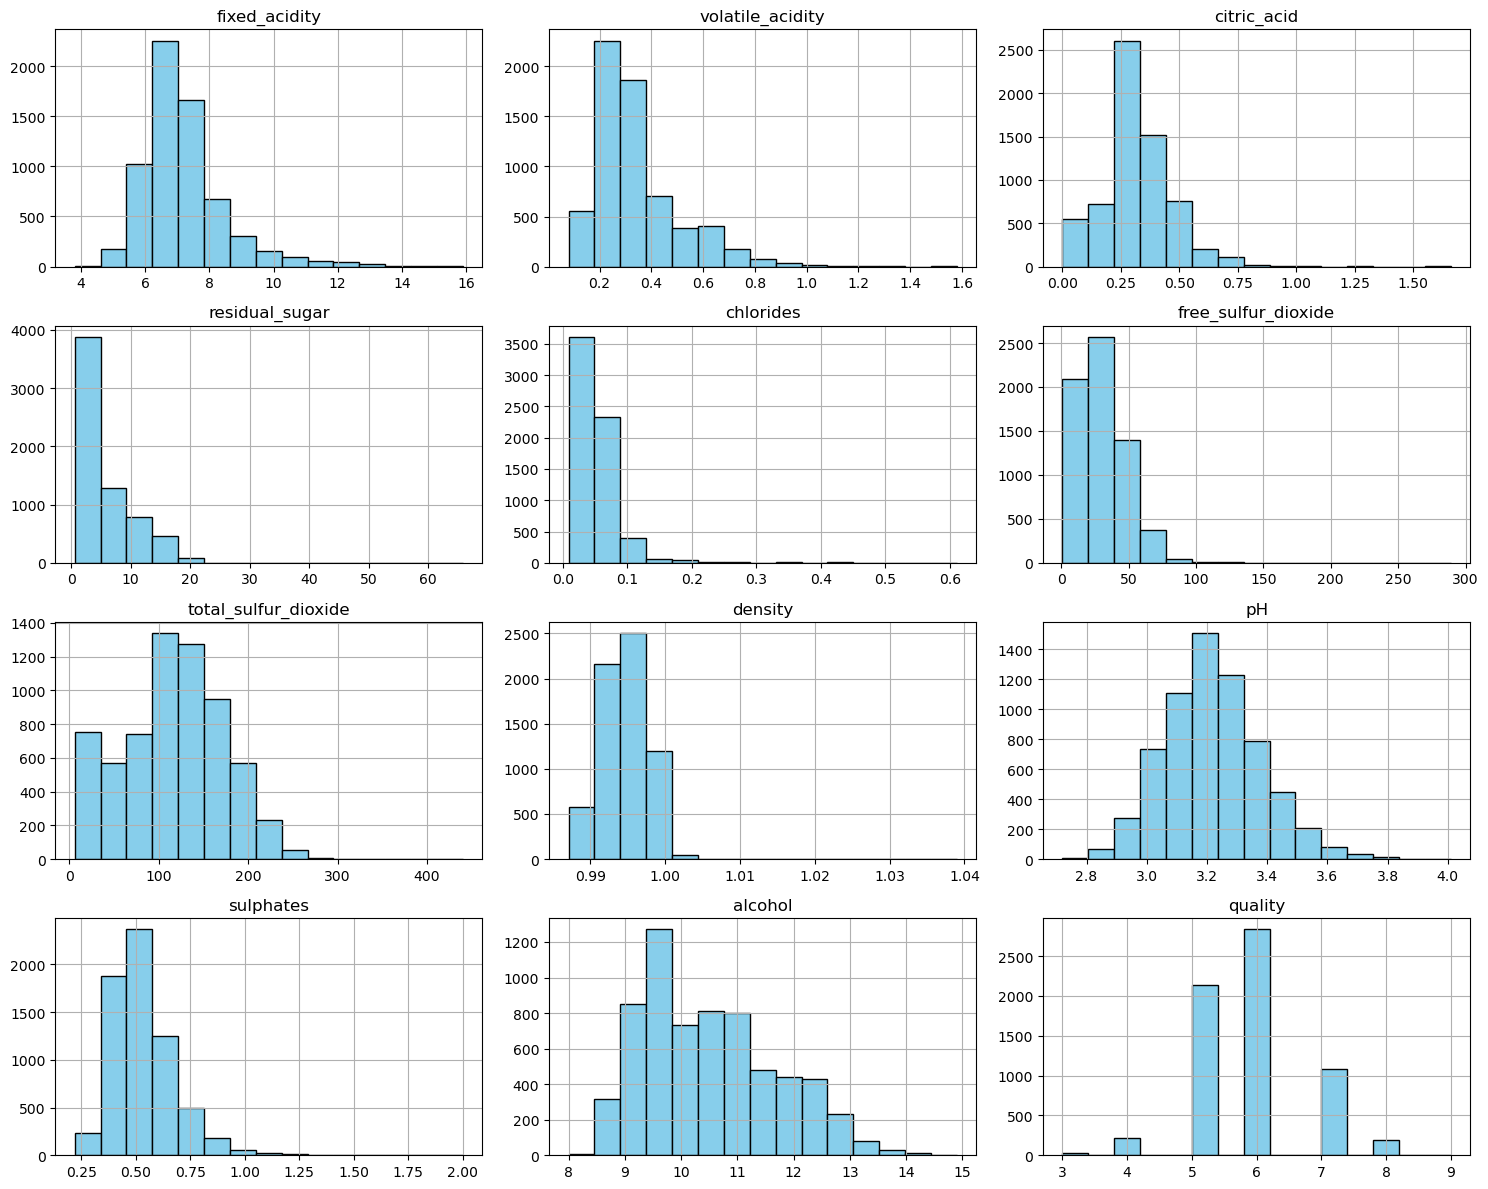

In [11]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your dataset and 'wine_type', 'metric_id', and 'quality' are the columns to exclude
df_filtered = df.drop(columns=['wine_type'])

# 1. Plot histograms for all numerical features
plt.figure(figsize=(15, 12))
df_filtered.hist(bins=15, figsize=(15, 12), color='skyblue', edgecolor='black')

plt.tight_layout()
plt.show()



In [12]:
df


,wine_type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,5


Outliers in 'fixed_acidity': 357 rows
Outliers in 'volatile_acidity': 376 rows
Outliers in 'citric_acid': 508 rows
Outliers in 'residual_sugar': 118 rows
Outliers in 'chlorides': 286 rows
Outliers in 'free_sulfur_dioxide': 62 rows
Outliers in 'total_sulfur_dioxide': 10 rows
Outliers in 'density': 3 rows
Outliers in 'pH': 73 rows
Outliers in 'sulphates': 191 rows
Outliers in 'alcohol': 3 rows
Outliers in 'quality': 228 rows


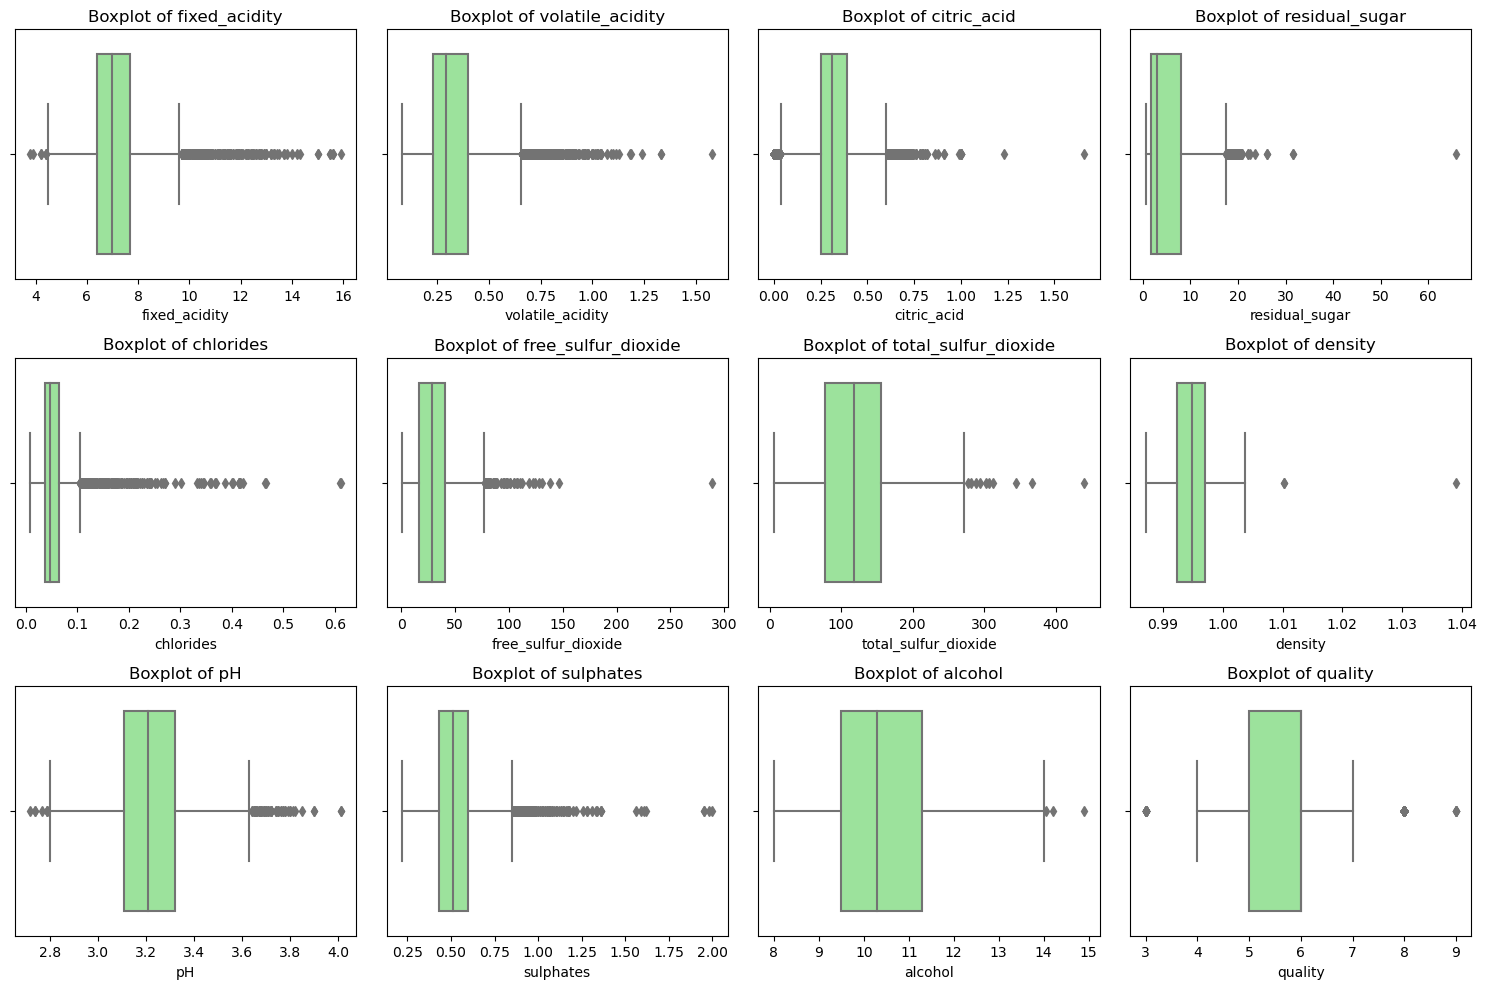

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# Step 1: Remove 'metric_id' and 'wine_type' columns
df_filtered = df.drop(columns=[ 'wine_type'])

# Step 2: Identify Outliers using IQR
def identify_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Q1, Q3 and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers

# Get the outliers in the DataFrame
outliers = identify_outliers(df_filtered)
for feature, data in outliers.items():
    print(f"Outliers in '{feature}': {data.shape[0]} rows")

# Step 3: Visualize outliers with boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(df_filtered.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data=df_filtered, x=feature, color='lightgreen')
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [14]:
# Convert 'wine_type' to numerical values, defaulting to 0 for unknown types
df['wine_type'] = df['wine_type'].apply(lambda x: 0 if x == 'white' else (1 if x == 'red' else 0))

# Verify the conversion
print(df['wine_type'].head())
df

0    0
1    0
2    0
3    0
4    0
Name: wine_type, dtype: int64


,wine_type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,6
1,0,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,6
2,0,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,6
3,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6
4,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,5
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,6
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,6
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,5


In [15]:

import dagshub
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/shubh0000007/my-first-repo.mlflow")
dagshub.init(repo_owner="shubh0000007", repo_name="my-first-repo")

Accessing as shubh0000007

Initialized MLflow to track repo "shubh0000007/my-first-repo"

Repository shubh0000007/my-first-repo initialized!

In [16]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.sklearn

# Load your dataset
data = df  # Replace 'df' with your actual DataFrame variable name
X = data.drop("quality", axis=1)  # Replace 'quality' with your target column name
y = data["quality"]  # Ensure 'quality' is your target variable (numeric)

# Convert numeric target to binary using a threshold
threshold = y.median()  # You can adjust this threshold to fit your case
y_binary = (y > threshold).astype(int)  # Convert to 0 or 1 based on the threshold

# Define preprocessors
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)
one_hot_encoder = OneHotEncoder()

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", scaler),
            ("minmax", minmax_scaler),
            ("log", log_transformer)
        ]), numerical_features),
        ("cat", one_hot_encoder, categorical_features)
    ])

# Create pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Hyperparameter tuning (for Logistic Regression)
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=3)

# Fit the GridSearchCV model before accessing best params
grid_search.fit(X, y_binary)

# Access the best parameters from GridSearchCV after fitting
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_penalty = best_params['classifier__penalty']

# Cross-validation and evaluation (using F1-score for classification)
cv_results = cross_val_score(pipeline, X, y_binary, scoring='f1', cv=10)
mean_f1 = np.mean(cv_results)
std_f1 = np.std(cv_results)

# Fit the model on the entire training data
pipeline.fit(X, y_binary)
y_pred = pipeline.predict(X)

# Calculate confusion matrix and metrics
tn, fp, fn, tp = confusion_matrix(y_binary, y_pred).ravel()
f1 = f1_score(y_binary, y_pred)

# Create a new experiment in MLFlow
experiment_name = "Experiment #1 - Logistic Regression Pipeline!!!"
try:
    # Try to create a new experiment
    mlflow.create_experiment(experiment_name)
except:
    # If the experiment already exists, use it
    mlflow.set_experiment(experiment_name)

# Log to MLFlow
mlflow.set_tracking_uri("https://dagshub.com/shubh0000007/my-first-repo.mlflow")  # Replace with your DagsHub URI
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    mlflow.log_param("scalers", ["StandardScaler", "MinMaxScaler", "Log Transformation"])
    mlflow.log_param("encoder", "OneHotEncoder")
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("C", best_C)  # Use the best 'C' parameter
    mlflow.log_param("penalty", best_penalty)  # Use the best penalty parameter
    mlflow.log_metric("mean_f1", mean_f1)
    mlflow.log_metric("std_f1", std_f1)
    mlflow.log_metric("f1_train", f1)
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline")

# Results
print(f"Mean F1-Score (CV): {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Training F1-Score: {f1:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/20 09:10:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run incongruous-dove-661 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/34/runs/b731b47fa0ba48daa51d004c4b832d02
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/34
Mean F1-Score (CV): 0.2570 ± 0.1223
Training F1-Score: 0.2981
Confusion Matrix: TP=251, TN=5064, FP=156, FN=1026


In [17]:
!pip install xgboost

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.sklearn

# Load your dataset
data = df  # Replace 'df' with your actual DataFrame variable name
X = data.drop("quality", axis=1)  # Replace 'quality' with your target column name
y = data["quality"]  # Ensure 'quality' is your target variable (numeric)

# Convert numeric target to binary using a threshold
threshold = y.median()  # Adjust this threshold if needed
y_binary = (y > threshold).astype(int)  # Convert to 0 or 1 based on the threshold

# Define preprocessors
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)
one_hot_encoder = OneHotEncoder()

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", scaler),
            ("minmax", minmax_scaler),
            ("log", log_transformer)
        ]), numerical_features),
        ("cat", one_hot_encoder, categorical_features)
    ])

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Create a new experiment in MLFlow
experiment_name = "Experiment #2 - Multiple Classifiers Pipelines!"
try:
    mlflow.create_experiment(experiment_name)
except:
    mlflow.set_experiment(experiment_name)

# Log to MLFlow
mlflow.set_tracking_uri("https://dagshub.com/shubh0000007/my-first-repo.mlflow")  # Replace with your DagsHub URI
mlflow.set_experiment(experiment_name)

for clf_name, clf in classifiers.items():
    # Create pipeline with the classifier
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])

    # Hyperparameter tuning (using GridSearchCV for simplicity)
    if clf_name == "Logistic Regression":
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2']
        }
    elif clf_name == "Ridge Classifier":
        param_grid = {
            'classifier__alpha': [0.1, 1, 10]
        }
    elif clf_name == "Random Forest":
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    elif clf_name == "XGBoost":
        param_grid = {
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.3]
        }

    grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=3)

    # Fit the GridSearchCV model before accessing best params
    grid_search.fit(X, y_binary)

    # Access the best parameters from GridSearchCV after fitting
    best_params = grid_search.best_params_

    # Cross-validation and evaluation (using F1-score for classification)
    cv_results = cross_val_score(pipeline, X, y_binary, scoring='f1', cv=10)
    mean_f1 = np.mean(cv_results)
    std_f1 = np.std(cv_results)

    # Fit the model on the entire training data
    pipeline.fit(X, y_binary)
    y_pred = pipeline.predict(X)

    # Calculate confusion matrix and metrics
    tn, fp, fn, tp = confusion_matrix(y_binary, y_pred).ravel()
    f1 = f1_score(y_binary, y_pred)

    with mlflow.start_run():
        mlflow.log_param("classifier", clf_name)
        mlflow.log_param("best_params", best_params)
        mlflow.log_param("scalers", ["StandardScaler", "MinMaxScaler", "Log Transformation"])
        mlflow.log_param("encoder", "OneHotEncoder")
        mlflow.log_param("model", clf_name)
        mlflow.log_metric("mean_f1", mean_f1)
        mlflow.log_metric("std_f1", std_f1)
        mlflow.log_metric("f1_train", f1)
        mlflow.log_metric("TP", tp)
        mlflow.log_metric("TN", tn)
        mlflow.log_metric("FP", fp)
        mlflow.log_metric("FN", fn)
        mlflow.sklearn.log_model(pipeline, f"{clf_name.lower().replace(' ', '_')}_pipeline")

    # Results for the classifier
    print(f"{clf_name} - Mean F1-Score (CV): {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"{clf_name} - Training F1-Score: {f1:.4f}")
    print(f"{clf_name} - Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/20 09:11:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run placid-grouse-620 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35/runs/8b7c5ccd044c44d59b45b6ca63084dd3
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35
Logistic Regression - Mean F1-Score (CV): 0.2570 ± 0.1223
Logistic Regression - Training F1-Score: 0.2981
Logistic Regression - Confusion Matrix: TP=251, TN=5064, FP=156, FN=1026


2024/12/20 09:11:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run upset-shad-234 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35/runs/54d10f0826d74d4cabae45551f0cb546
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35
Ridge Classifier - Mean F1-Score (CV): 0.1879 ± 0.1462
Ridge Classifier - Training F1-Score: 0.2112
Ridge Classifier - Confusion Matrix: TP=158, TN=5159, FP=61, FN=1119


2024/12/20 09:14:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run unequaled-colt-198 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35/runs/20f7f520e18d4c8f8978a48f64dc1e7b
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35
Random Forest - Mean F1-Score (CV): 0.3732 ± 0.1264
Random Forest - Training F1-Score: 1.0000
Random Forest - Confusion Matrix: TP=1277, TN=5220, FP=0, FN=0


2024/12/20 09:15:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run big-fly-579 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35/runs/6cd349574cce48e281836704344885ed
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/35
XGBoost - Mean F1-Score (CV): 0.3702 ± 0.0861
XGBoost - Training F1-Score: 0.9861
XGBoost - Confusion Matrix: TP=1246, TN=5216, FP=4, FN=31


In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn


# Feature Engineering: Combine features
df['acidity_level'] = df['fixed_acidity'] + df['volatile_acidity'] + df['citric_acid']
df['total_sulfur'] = df['free_sulfur_dioxide'] + df['total_sulfur_dioxide']
df['sugar_alcohol_interaction'] = df['residual_sugar'] * df['alcohol']
df['density_ph_interaction'] = df['density'] * df['pH']


# Define features (X) and target variable (y)
X = df.drop('quality', axis=1)
y = df['quality']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Set or create the MLFlow experiment
mlflow.set_experiment('#3 Feature engineerings!!')

# Log experiment in MLFlow
with mlflow.start_run():
    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param('n_estimators', rf.n_estimators)
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' for multi-class F1 score
    cm = confusion_matrix(y_test, y_pred)
    
    # Log metrics
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1_score', f1)
    
    # Log the model
    mlflow.sklearn.log_model(rf, 'random_forest_model')
    
    # Print out the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Print TP, TN, FP, FN for each class
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        
        print(f"\nClass {i}:")
        print(f"True Positives (TP): {tp}")
        print(f"False Negatives (FN): {fn}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")


2024/12/20 09:15:36 INFO mlflow.tracking.fluent: Experiment with name '#3 Feature engineerings!!' does not exist. Creating a new experiment.
2024/12/20 09:15:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.6938
F1 Score: 0.6795
Confusion Matrix:
[[  0   0   2   0   0   0]
 [  0   6  23  15   2   0]
 [  0   0 321  97   2   0]
 [  0   0  93 455  31   0]
 [  0   0   5 103 112   1]
 [  0   0   1  14   9   8]]

Class 0:
True Positives (TP): 0
False Negatives (FN): 2
False Positives (FP): 0
True Negatives (TN): 1298

Class 1:
True Positives (TP): 6
False Negatives (FN): 40
False Positives (FP): 0
True Negatives (TN): 1254

Class 2:
True Positives (TP): 321
False Negatives (FN): 99
False Positives (FP): 124
True Negatives (TN): 756

Class 3:
True Positives (TP): 455
False Negatives (FN): 124
False Positives (FP): 229
True Negatives (TN): 492

Class 4:
True Positives (TP): 112
False Negatives (FN): 109
False Positives (FP): 44
True Negatives (TN): 1035

Class 5:
True Positives (TP): 8
False Negatives (FN): 24
False Positives (FP): 1
True Negatives (TN): 1267
🏃 View run placid-grub-198 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/36/runs/21f12932c0aa4769a3f6

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Assuming df is your dataset
# Define features (X) and target variable (y)
X = df.drop('quality', axis=1)
y = df['quality']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MLFlow experiment setup
mlflow.set_experiment('#4 Correlation Threshold, Feature Importance, and Variances!!!')

# Feature Selection - 1: Correlation Threshold
def correlation_threshold(X, feature_names, threshold=0.9):
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    # Create a mask for highly correlated features
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)
    to_drop = [i for i in range(corr_matrix.shape[0]) if any(corr_matrix[i, j] > threshold for j in range(corr_matrix.shape[1]))]
    # Remove features that have a high correlation with others
    removed_features = [feature_names[i] for i in to_drop]
    X_selected = np.delete(X, to_drop, axis=1)
    return X_selected, removed_features

# Feature Selection - 2: Feature Importance using Random Forest
def feature_importance(X_train, y_train, X_test, feature_names, threshold=0.05):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    # Select features with importance greater than threshold
    selected_features = np.where(importances > threshold)[0]
    removed_features = [feature_names[i] for i in range(len(importances)) if importances[i] <= threshold]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]
    return X_train_selected, X_test_selected, selected_features, importances, removed_features

# Feature Selection - 3: Variance Threshold
def variance_threshold(X, feature_names, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X)
    removed_features = [feature_names[i] for i in range(len(X[0])) if i not in selector.get_support(indices=True)]
    return X_selected, removed_features

# Start experiment logging in MLFlow
with mlflow.start_run():

    # Log parameters
    mlflow.log_param('correlation_threshold', 0.9)
    mlflow.log_param('importance_threshold', 0.05)
    mlflow.log_param('variance_threshold', 0.01)

    # Correlation Threshold Selection
    X_corr, removed_corr_features = correlation_threshold(X_scaled, X.columns)
    mlflow.log_param('removed_corr_features', removed_corr_features)
    
    # Variance Threshold Selection
    X_var, removed_var_features = variance_threshold(X_scaled, X.columns)
    mlflow.log_param('removed_var_features', removed_var_features)

    # Feature Importance Selection
    X_imp, X_test_imp, selected_features, importances, removed_importance_features = feature_importance(X_train, y_train, X_test, X.columns)
    mlflow.log_param('selected_features_importance', selected_features)

    # Train the model using RandomForestClassifier on the selected features
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_imp, y_train)
    y_pred = rf.predict(X_test_imp)

    # Calculate accuracy and f1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' for multi-class F1 score

    # Log metrics in MLFlow
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1_score', f1)

    # Log the model
    mlflow.sklearn.log_model(rf, 'random_forest_model')

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Removed Features due to Correlation Threshold: {removed_corr_features}")
    print(f"Removed Features due to Variance Threshold: {removed_var_features}")
    print(f"Removed Features based on Importance: {removed_importance_features}")
    print(f"Selected Features based on Importance: {selected_features}")
    print("Feature Importances:")
    for i, imp in enumerate(importances):
        print(f"Feature {X.columns[i]}: {imp:.4f}")


2024/12/20 09:16:11 INFO mlflow.tracking.fluent: Experiment with name '#4 Correlation Threshold, Feature Importance, and Variances!!!' does not exist. Creating a new experiment.
2024/12/20 09:16:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.6946
F1 Score: 0.6792
Removed Features due to Correlation Threshold: ['wine_type', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'acidity_level', 'total_sulfur', 'sugar_alcohol_interaction', 'density_ph_interaction']
Removed Features due to Variance Threshold: []
Removed Features based on Importance: ['wine_type', 'fixed_acidity']
Selected Features based on Importance: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Feature Importances:
Feature wine_type: 0.0018
Feature fixed_acidity: 0.0482
Feature volatile_acidity: 0.0832
Feature citric_acid: 0.0622
Feature residual_sugar: 0.0536
Feature chlorides: 0.0671
Feature free_sulfur_dioxide: 0.0640
Feature total_sulfur_dioxide: 0.0638
Feature density: 0.0785
Feature pH: 0.0503
Feature sulphates: 0.0688
Feature alcohol: 0.1071
Feature acidity_level: 0.0622
Feature total_sulfur: 0.0618
Feature sugar_alcohol_inter

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import mlflow
import mlflow.sklearn

# Load your dataframe (make sure to load it correctly)
# df = pd.read_csv('your_data.csv')  # Uncomment and adjust if needed

# Define features (X) and target variable (y)
X = df.drop('quality', axis=1)
y = df['quality']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine number of components for 95% variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Reduce dimensions using PCA
pca = PCA(n_components=num_components)
X_reduced = pca.fit_transform(X_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Scree plot creation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
scree_plot_path = 'scree_plot.png'
plt.savefig(scree_plot_path)
plt.close()

# PCA 2D scatter plot (first two principal components)
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA 2D Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Quality')
pca_scatter_plot_path = 'pca_scatter_plot.png'
plt.savefig(pca_scatter_plot_path)
plt.close()

# PCA graph showing variance up to 95%
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components + 1), cumulative_explained_variance[:num_components], marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title(f'PCA Components up to 95% Variance ({num_components} Components)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
pca_95_variance_plot_path = 'pca_95_variance_plot.png'
plt.savefig(pca_95_variance_plot_path)
plt.close()

# Print feature contributions to each principal component
components_df = pd.DataFrame(pca.components_, columns=X.columns)
print("Feature contributions to principal components (loadings):")
print(components_df)

# MLFlow experiment setup
mlflow.set_experiment('Experiment #5: PCA for Dimensionality Reductions!!')

# Log results in MLFlow
with mlflow.start_run():
    # Log PCA explained variance metrics
    explained_variance_95 = cumulative_explained_variance[num_components - 1]
    mlflow.log_metric('explained_variance_95', explained_variance_95)  # Removed '%' from the name
    mlflow.log_param('num_components', num_components)

    for i, var in enumerate(explained_variance_ratio[:num_components]):
        mlflow.log_metric(f'pca_explained_variance_ratio_component_{i+1}', var)

    # Log model
    mlflow.sklearn.log_model(model, 'random_forest_model')

    # Log metrics
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1_score', f1)

    # Log scree plot, PCA scatter plot, and PCA 95% variance plot as artifacts
    mlflow.log_artifact(scree_plot_path)
    mlflow.log_artifact(pca_scatter_plot_path)
    mlflow.log_artifact(pca_95_variance_plot_path)

    print(f"Explained Variance (95%): {explained_variance_95:.4f}")
    print(f"Number of Components: {num_components}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Scree plot, PCA scatter plot, and PCA 95% variance plot saved and logged to MLflow.")


Feature contributions to principal components (loadings):
   wine_type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0  -0.376510      -0.209481         -0.268523     0.088067        0.273547   
1   0.127173       0.386896          0.059309     0.237223        0.273613   
2   0.147960      -0.212640          0.225782    -0.285011        0.245541   
3  -0.003070       0.109543         -0.226919     0.406854       -0.290201   
4  -0.029756       0.142707         -0.249838     0.349996        0.276332   
5  -0.016326      -0.333178         -0.164490     0.118012        0.190706   
6   0.135832       0.120412          0.484544    -0.273242        0.062839   
7   0.022411      -0.081428          0.277728     0.413060        0.051417   
8   0.203583       0.164335         -0.550600    -0.366430        0.037145   

   chlorides  free_sulfur_dioxide  total_sulfur_dioxide   density        pH  \
0  -0.204579             0.316441              0.378023 -0.043852 -0.166178   
1  

2024/12/20 09:17:30 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #5: PCA for Dimensionality Reductions!!' does not exist. Creating a new experiment.
2024/12/20 09:17:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Explained Variance (95%): 0.9707
Number of Components: 9
Accuracy: 0.6762
F1 Score: 0.6633
Scree plot, PCA scatter plot, and PCA 95% variance plot saved and logged to MLflow.
🏃 View run gaudy-rat-340 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/38/runs/d111469884b94913a7ac2f77df038843
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/38


In [22]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Set the experiment name in MLFlow
mlflow.set_experiment('#6 SVC_Custom_Experiments!')

# Preprocessing
# Assume 'quality' is the target variable and all others are features
X = df.drop('quality', axis=1)
y = df['quality']

# Encoding the target variable if it's categorical
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode categorical labels

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (Stratified Split to ensure all classes are represented)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Start the MLFlow experiment run
with mlflow.start_run():

    # Define the Support Vector Classifier (SVC) model
    model_svc = SVC(probability=True, random_state=42)
    
    # Train the model
    model_svc.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_svc = model_svc.predict(X_test)
    
    # Calculate various metrics
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

    # Binarize the labels for ROC AUC calculation (only if it's a multi-class classification)
    y_bin = label_binarize(y_test, classes=np.unique(y_encoded))
    
    # Calculate ROC AUC if there are at least two classes
    if len(np.unique(y_test)) > 1:
        roc_auc_svc = roc_auc_score(y_bin, model_svc.predict_proba(X_test), average='macro', multi_class='ovr')
        mlflow.log_metric('SVC_roc_auc', roc_auc_svc)
    else:
        print("Warning: Only one class present in y_test, ROC AUC not calculated.")
        roc_auc_svc = None

    # Log metrics in MLFlow
    mlflow.log_metric('SVC_accuracy', accuracy_svc)
    mlflow.log_metric('SVC_f1_score', f1_svc)

    # Log the trained model in MLFlow
    mlflow.sklearn.log_model(model_svc, 'SupportVectorClassifier')

    # Confusion Matrix
    conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
    
    if conf_matrix_svc.shape == (2, 2):  # Binary classification
        tn_svc, fp_svc, fn_svc, tp_svc = conf_matrix_svc.ravel()
        print(f"SVC Confusion Matrix Components:")
        print(f"  True Negatives (TN): {tn_svc}")
        print(f"  False Positives (FP): {fp_svc}")
        print(f"  False Negatives (FN): {fn_svc}")
        print(f"  True Positives (TP): {tp_svc}")
    else:
        print("SVC Confusion Matrix (Multi-Class):")
        print(conf_matrix_svc)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix_svc, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix: Support Vector Classifier")
    plt.colorbar()
    plt.xticks(np.arange(len(encoder.classes_)), encoder.classes_, rotation=45)
    plt.yticks(np.arange(len(encoder.classes_)), encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    conf_matrix_path_svc = 'SVC_confusion_matrix.png'
    plt.savefig(conf_matrix_path_svc)
    plt.close()

    # Log confusion matrix as an artifact
    mlflow.log_artifact(conf_matrix_path_svc)

    # Print results
    print(f"Support Vector Classifier Results:")
    print(f"  Accuracy: {accuracy_svc:.4f}")
    print(f"  F1 Score: {f1_svc:.4f}")
    if roc_auc_svc is not None:
        print(f"  ROC AUC: {roc_auc_svc:.4f}")
    print("Confusion matrix logged to MLFlow.")


2024/12/20 09:17:58 INFO mlflow.tracking.fluent: Experiment with name '#6 SVC_Custom_Experiments!' does not exist. Creating a new experiment.
2024/12/20 09:18:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC Confusion Matrix (Multi-Class):
[[  0   0   3   3   0   0   0]
 [  0   0  30  12   1   0   0]
 [  0   0 282 146   0   0   0]
 [  0   0 128 414  25   0   0]
 [  0   0  11 158  47   0   0]
 [  0   0   0  26  13   0   0]
 [  0   0   0   1   0   0   0]]
Support Vector Classifier Results:
  Accuracy: 0.5715
  F1 Score: 0.5344
  ROC AUC: 0.8239
Confusion matrix logged to MLFlow.
🏃 View run popular-stag-48 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/39/runs/e836aecf093148eda39e226841da5a22
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/39


In [23]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Set the experiment name in MLFlow
mlflow.set_experiment('7 KNN_vs_SVM_Custom_Experiments!')


X = df.drop('quality', axis=1)
y = df['quality']

# Encode the target variable if it's categorical
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode categorical labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (Stratified Split to ensure all classes are represented)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Start the MLFlow experiment run
with mlflow.start_run():

    ### K-Nearest Neighbors (KNN) ###
    # Define the KNN model
    model_knn = KNeighborsClassifier(n_neighbors=5)
    
    # Train the KNN model
    model_knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_knn = model_knn.predict(X_test)
    
    # Calculate metrics for KNN
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

    # Binarize the labels for ROC AUC calculation (only if it's a multi-class classification)
    y_bin = label_binarize(y_test, classes=np.unique(y_encoded))
    
    # Calculate ROC AUC if there are at least two classes
    if len(np.unique(y_test)) > 1:
        roc_auc_knn = roc_auc_score(y_bin, model_knn.predict_proba(X_test), average='macro', multi_class='ovr')
        mlflow.log_metric('KNN_roc_auc', roc_auc_knn)
    else:
        print("Warning: Only one class present in y_test, ROC AUC not calculated.")
        roc_auc_knn = None

    # Log metrics for KNN
    mlflow.log_metric('KNN_accuracy', accuracy_knn)
    mlflow.log_metric('KNN_f1_score', f1_knn)

    # Log the trained KNN model in MLFlow
    mlflow.sklearn.log_model(model_knn, 'KNN_Classifier')

    # Confusion Matrix for KNN
    conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

    if conf_matrix_knn.shape == (2, 2):  # Binary classification
        tn_knn, fp_knn, fn_knn, tp_knn = conf_matrix_knn.ravel()
        print(f"KNN Confusion Matrix Components:")
        print(f"  True Negatives (TN): {tn_knn}")
        print(f"  False Positives (FP): {fp_knn}")
        print(f"  False Negatives (FN): {fn_knn}")
        print(f"  True Positives (TP): {tp_knn}")
    else:
        print("KNN Confusion Matrix (Multi-Class):")
        print(conf_matrix_knn)

    # Plot and log confusion matrix for KNN
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix_knn, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix: K-Nearest Neighbors")
    plt.colorbar()
    plt.xticks(np.arange(len(encoder.classes_)), encoder.classes_, rotation=45)
    plt.yticks(np.arange(len(encoder.classes_)), encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    conf_matrix_path_knn = 'KNN_confusion_matrix.png'
    plt.savefig(conf_matrix_path_knn)
    plt.close()

    # Log confusion matrix as an artifact
    mlflow.log_artifact(conf_matrix_path_knn)

    ### Support Vector Machine (SVM) ###
    # Define the SVM model
    model_svm = SVC(probability=True, kernel='linear', random_state=42)
    
    # Train the SVM model
    model_svm.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_svm = model_svm.predict(X_test)
    
    # Calculate metrics for SVM
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

    # Calculate ROC AUC for SVM
    if len(np.unique(y_test)) > 1:
        roc_auc_svm = roc_auc_score(y_bin, model_svm.predict_proba(X_test), average='macro', multi_class='ovr')
        mlflow.log_metric('SVM_roc_auc', roc_auc_svm)
    else:
        print("Warning: Only one class present in y_test, ROC AUC not calculated.")
        roc_auc_svm = None

    # Log metrics for SVM
    mlflow.log_metric('SVM_accuracy', accuracy_svm)
    mlflow.log_metric('SVM_f1_score', f1_svm)

    # Log the trained SVM model in MLFlow
    mlflow.sklearn.log_model(model_svm, 'SVM_Classifier')

    # Confusion Matrix for SVM
    conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

    if conf_matrix_svm.shape == (2, 2):  # Binary classification
        tn_svm, fp_svm, fn_svm, tp_svm = conf_matrix_svm.ravel()
        print(f"SVM Confusion Matrix Components:")
        print(f"  True Negatives (TN): {tn_svm}")
        print(f"  False Positives (FP): {fp_svm}")
        print(f"  False Negatives (FN): {fn_svm}")
        print(f"  True Positives (TP): {tp_svm}")
    else:
        print("SVM Confusion Matrix (Multi-Class):")
        print(conf_matrix_svm)

    # Plot and log confusion matrix for SVM
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix_svm, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix: Support Vector Machine")
    plt.colorbar()
    plt.xticks(np.arange(len(encoder.classes_)), encoder.classes_, rotation=45)
    plt.yticks(np.arange(len(encoder.classes_)), encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    conf_matrix_path_svm = 'SVM_confusion_matrix.png'
    plt.savefig(conf_matrix_path_svm)
    plt.close()

    # Log confusion matrix as an artifact
    mlflow.log_artifact(conf_matrix_path_svm)

    # Print results for KNN and SVM
    print(f"KNN Results:")
    print(f"  Accuracy: {accuracy_knn:.4f}")
    print(f"  F1 Score: {f1_knn:.4f}")
    if roc_auc_knn is not None:
        print(f"  ROC AUC: {roc_auc_knn:.4f}")
    
    print(f"SVM Results:")
    print(f"  Accuracy: {accuracy_svm:.4f}")
    print(f"  F1 Score: {f1_svm:.4f}")
    if roc_auc_svm is not None:
        print(f"  ROC AUC: {roc_auc_svm:.4f}")
    
    print("Confusion matrices logged to MLFlow.")


2024/12/20 09:18:53 INFO mlflow.tracking.fluent: Experiment with name '7 KNN_vs_SVM_Custom_Experiments!' does not exist. Creating a new experiment.
2024/12/20 09:19:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN Confusion Matrix (Multi-Class):
[[  0   1   3   2   0   0   0]
 [  1   4  22  16   0   0   0]
 [  0   9 284 123  12   0   0]
 [  0   5 177 333  52   0   0]
 [  0   0  24 101  89   2   0]
 [  0   1   1  13  21   3   0]
 [  0   0   0   0   1   0   0]]


2024/12/20 09:20:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM Confusion Matrix (Multi-Class):
[[  0   0   2   4   0   0   0]
 [  0   0  28  15   0   0   0]
 [  0   0 266 162   0   0   0]
 [  0   0 147 420   0   0   0]
 [  0   0  20 196   0   0   0]
 [  0   0   2  37   0   0   0]
 [  0   0   0   1   0   0   0]]
KNN Results:
  Accuracy: 0.5485
  F1 Score: 0.5346
  ROC AUC: 0.6848
SVM Results:
  Accuracy: 0.5277
  F1 Score: 0.4575
  ROC AUC: 0.7806
Confusion matrices logged to MLFlow.
🏃 View run debonair-snake-958 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/40/runs/ad84814642074d05b86a69369fcdf0bd
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/40


2024/12/20 11:53:32 INFO mlflow.tracking.fluent: Experiment with name '#8 Model_Comparison_Experiments!!!!!' does not exist. Creating a new experiment.


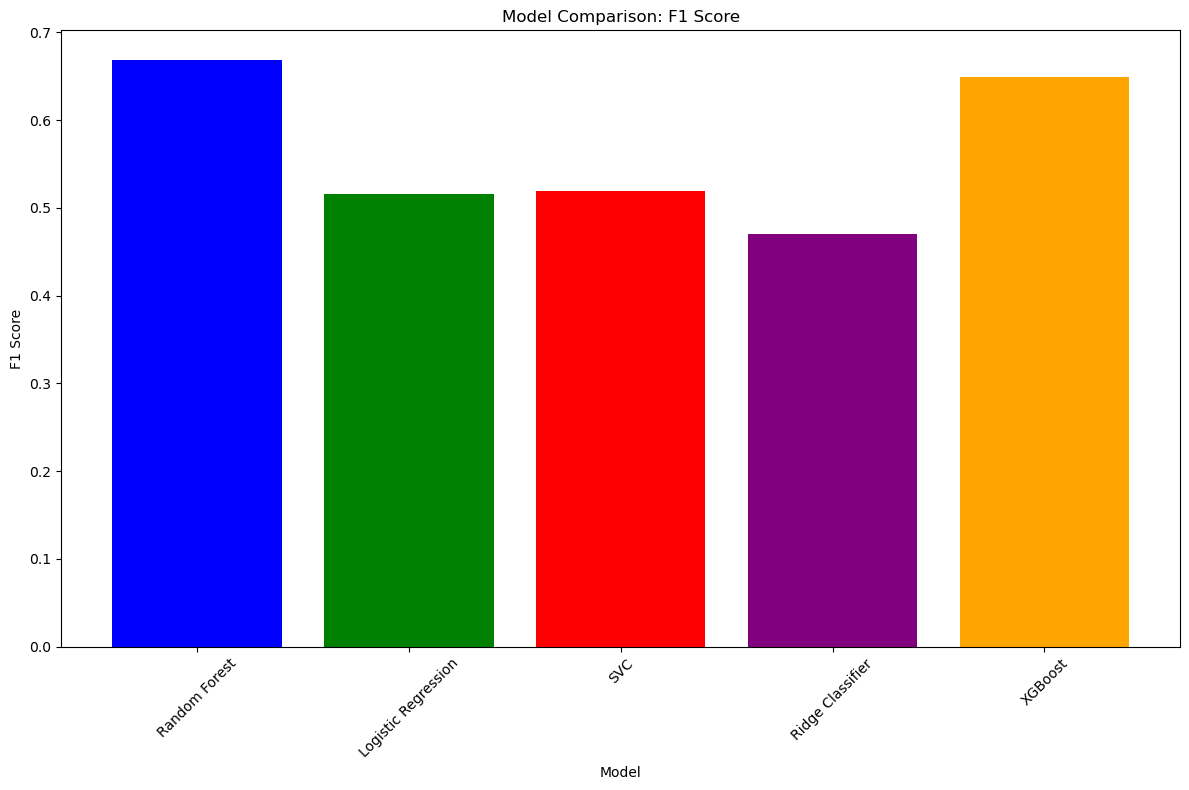

Experiment and results logged to MLFlow.
🏃 View run delicate-kit-748 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/45/runs/51f321cec31b449d93c370f6d3d6cefa
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/45


In [50]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import xgboost as xgb

# Set the experiment name in MLFlow
mlflow.set_experiment('#8 Model_Comparison_Experiments!!!!!')

# Sample dataset (replace with your actual dataset)
# Assuming 'df' is your DataFrame with 'quality' as target variable
# Ensure that 'df' is already defined with the proper data
X = df.drop('quality', axis=1)
y = df['quality']

# Encode the target variable if it's categorical
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode categorical labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (Stratified Split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded)

# Store F1-scores for comparison
model_names = []
f1_scores = []

# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_names.append(model_name)
    f1_scores.append(f1)
    return f1

# Start the MLFlow experiment run
with mlflow.start_run():

    # 1. Random Forest Model
    model_rf = RandomForestClassifier(random_state=42)
    f1_rf = train_and_evaluate(model_rf, 'Random Forest')

    # 2. Logistic Regression Model
    model_lr = LogisticRegression(random_state=42, max_iter=1000)
    f1_lr = train_and_evaluate(model_lr, 'Logistic Regression')

    # 3. SVC Model
    model_svc = SVC(probability=True, random_state=42)
    f1_svc = train_and_evaluate(model_svc, 'SVC')

    # 4. Ridge Classifier Model
    model_ridge = RidgeClassifier()
    f1_ridge = train_and_evaluate(model_ridge, 'Ridge Classifier')

    # 5. XGBoost Classifier Model
    model_xgb = xgb.XGBClassifier(random_state=42)
    f1_xgb = train_and_evaluate(model_xgb, 'XGBoost')

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Model': model_names,
        'F1 Score': f1_scores
    })

    # Log F1-scores in MLFlow
    for model_name, f1 in zip(model_names, f1_scores):
        mlflow.log_metric(f'{model_name}_f1_score', f1)

    # Plot the F1-scores using a bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(results_df['Model'], results_df['F1 Score'], color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title('Model Comparison: F1 Score')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot as an artifact
    plt.savefig('F1_score_comparison_plot.png')

    # Log the plot as an artifact in MLFlow
    mlflow.log_artifact('F1_score_comparison_plot.png')

    # Show the plot
    plt.show()

    print("Experiment and results logged to MLFlow.")


In [57]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

# Set the experiment name in MLFlow
mlflow.set_experiment('#9 random_Experiment')

# Sample dataset (replace with your actual dataset)
# Assuming 'df' is your DataFrame with 'quality' as the target variable
# Ensure that 'df' is already defined with the proper data
X = df.drop('quality', axis=1)
y = df['quality']

# Encode the target variable if it's categorical
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode categorical labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (Stratified Split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded)

# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    return f1, accuracy

# Start the MLFlow experiment run
with mlflow.start_run():

    # 1. Random Forest Model
    model_rf = RandomForestClassifier()
    f1_rf, accuracy_rf = train_and_evaluate(model_rf, 'Random Forest')

    # Log the F1 score and accuracy of the Random Forest model
    mlflow.log_metric('Random_Forest_f1_score', f1_rf)
    mlflow.log_metric('Random_Forest_accuracy', accuracy_rf)

    # Log the Random Forest model
    mlflow.sklearn.log_model(model_rf, "random_forest_model")

    print(f"Random Forest Model F1 Score: {f1_rf}")
    print(f"Random Forest Model Accuracy: {accuracy_rf}")
    print("Random Forest model logged to MLFlow.")


2024/12/20 12:11:49 INFO mlflow.tracking.fluent: Experiment with name '#9 random_Experiment' does not exist. Creating a new experiment.
2024/12/20 12:12:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Model F1 Score: 0.6695501279135309
Random Forest Model Accuracy: 0.6807692307692308
Random Forest model logged to MLFlow.
🏃 View run beautiful-ox-574 at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/48/runs/b16713df23474ea0965a9153b7e97362
🧪 View experiment at: https://dagshub.com/shubh0000007/my-first-repo.mlflow/#/experiments/48


In [58]:
joblib.dump(model_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']